In [ ]:

# Instalar bibliotecas necessárias

# Desinstalar numpy atual (que vem pré-instalado no Colab)
!pip uninstall -y numpy

# Instalar numpy novamente (versão compatível)
!pip install numpy==1.23.5

# Instalar scikit-surprise
!pip install scikit-surprise

!pip install scikit-learn pandas numpy seaborn matplotlib


Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have nump

In [ ]:

# Download da base MovieLens 100k
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip


--2025-06-03 23:02:23--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.1’

ml-100k.zip.1       100%[===================>]   4.70M  11.0MB/s    in 0.4s    

2025-06-03 23:02:23 (11.0 MB/s) - ‘ml-100k.zip.1’ saved [4924029/4924029]

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:

import pandas as pd

# Carregar dados de avaliações
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings.head()


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:

movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1',
                      names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                             'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
                             'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                             'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
movies = movies[['item_id', 'title', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]
movies.head()


,item_id,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:

from surprise import Dataset, Reader, KNNBasic, SVD, accuracy
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# KNN User-Based
sim_options = {'name': 'cosine', 'user_based': True}
model_knn_user = KNNBasic(sim_options=sim_options)
model_knn_user.fit(trainset)
predictions_knn_user = model_knn_user.test(testset)
print("KNN User-Based")
accuracy.rmse(predictions_knn_user)
accuracy.mae(predictions_knn_user)


Computing the cosine similarity matrix...
Done computing similarity matrix.
KNN User-Based
RMSE: 1.0194
MAE:  0.8038


0.8037993357440609

In [ ]:

# SVD
model_svd = SVD()
model_svd.fit(trainset)
predictions_svd = model_svd.test(testset)
print("SVD")
accuracy.rmse(predictions_svd)
accuracy.mae(predictions_svd)


SVD
RMSE: 0.9336
MAE:  0.7371


0.7371488931381301

In [ ]:

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

movie_features = movies.set_index('item_id').drop('title', axis=1)
cosine_sim = cosine_similarity(movie_features)
indices = pd.Series(movie_features.index)

def get_content_recommendations(item_id, top_n=5):
    idx = indices[indices == item_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return indices.iloc[movie_indices].values

movie_id = 50
recommended = get_content_recommendations(movie_id, top_n=5)
print("Filmes recomendados:", recommended)


Filmes recomendados: [181 172 271 498  62]


In [ ]:

def get_svd_score(user_id, item_id):
    pred = model_svd.predict(str(user_id), str(item_id))
    return pred.est

def hybrid_score(user_id, item_id, alpha=0.5):
    svd_score = get_svd_score(user_id, item_id)
    user_rated = ratings[(ratings['user_id'] == int(user_id)) & (ratings['rating'] >= 4)]['item_id']
    if len(user_rated) == 0:
        content_score = 0
    else:
        idx_target = indices[indices == item_id].index[0]
        idx_rated = [indices[indices == i].index[0] for i in user_rated if i in indices.values]
        sim_scores = cosine_sim[idx_target, idx_rated]
        content_score = np.mean(sim_scores) if len(sim_scores) > 0 else 0
    final_score = alpha * svd_score + (1 - alpha) * content_score
    return final_score

user_id = 100
item_id = 50
score = hybrid_score(user_id, item_id, alpha=0.5)
print(f'Score híbrido para usuário {user_id} e filme {item_id}: {score}')


Score híbrido para usuário 100 e filme 50: 1.85766908334754


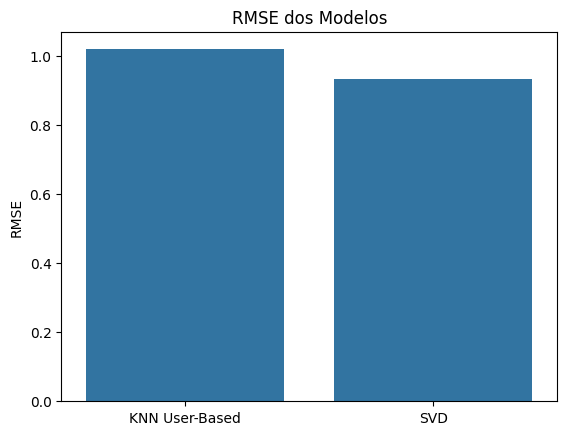

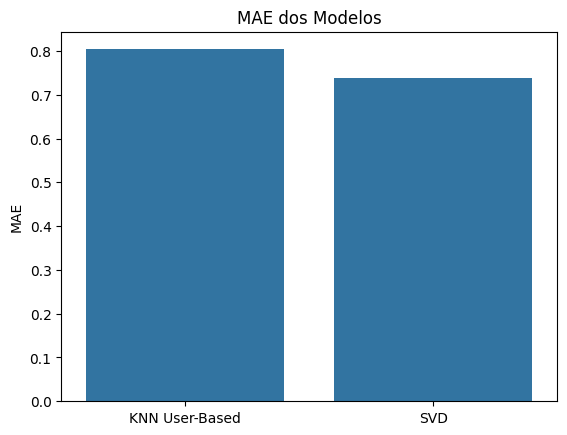

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

rmse_scores = {
    'KNN User-Based': accuracy.rmse(predictions_knn_user, verbose=False),
    'SVD': accuracy.rmse(predictions_svd, verbose=False)
}

mae_scores = {
    'KNN User-Based': accuracy.mae(predictions_knn_user, verbose=False),
    'SVD': accuracy.mae(predictions_svd, verbose=False)
}

sns.barplot(x=list(rmse_scores.keys()), y=list(rmse_scores.values()))
plt.title('RMSE dos Modelos')
plt.ylabel('RMSE')
plt.show()

sns.barplot(x=list(mae_scores.keys()), y=list(mae_scores.values()))
plt.title('MAE dos Modelos')
plt.ylabel('MAE')
plt.show()


In [ ]:
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=movie_features.index,
    columns=movie_features.index
)

def content_recommend_for_user(user_id, top_n=10):
    user_data = ratings[ratings['user_id'] == user_id]
    watched_items = set(user_data['item_id'])
    high_rated_items = set(user_data[user_data['rating'] >= 4]['item_id'])

    if not high_rated_items:
        return []  # Nenhum item relevante, retorna vazio

    # Calcular média das similaridades dos filmes não assistidos
    candidate_items = set(movie_features.index) - watched_items

    sims = cosine_sim_df.loc[list(candidate_items), list(high_rated_items)]
    mean_scores = sims.mean(axis=1)

    # Ordenar e pegar os top-N
    top_items = mean_scores.sort_values(ascending=False).head(top_n).index.tolist()
    return top_items



In [ ]:
def precision_recall_at_k(user_id, k=10):
    user_data = ratings[ratings['user_id'] == user_id]
    relevant_items = set(user_data[user_data['rating'] >= 4]['item_id'])

    if not relevant_items:
        return None, None  # Nenhum relevante para este usuário

    recommended_items = content_recommend_for_user(user_id, top_n=k)
    recommended_set = set(recommended_items)

    hits = len(relevant_items & recommended_set)

    precision = hits / k
    recall = hits / len(relevant_items)

    return precision, recall


In [ ]:
user_ids = ratings['user_id'].unique()

precisions = []
recalls = []

for user_id in user_ids:
    prec, rec = precision_recall_at_k(user_id, k=10)
    if prec is not None and rec is not None:
        precisions.append(prec)
        recalls.append(rec)

# Resultados médios
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

print(f"Precision@10 média: {avg_precision:.4f}")
print(f"Recall@10 média: {avg_recall:.4f}")


Precision@10 média: 0.0000
Recall@10 média: 0.0000


In [ ]:
# teste com algum usuário
user_id = 100
recom = content_recommend_for_user(user_id, top_n=10)
print("Filmes recomendados para usuário", user_id, ":", recom)

relevant = ratings[(ratings['user_id'] == user_id) & (ratings['rating'] >= 4)]['item_id'].tolist()

print("Filmes relevantes para o usuário:", relevant)

common_items = list(set(recom) & set(relevant))
print(common_items)


Filmes recomendados para usuário 100 : [917, 1559, 28, 1025, 244, 1491, 1556, 54, 337, 591]
Filmes relevantes para o usuário: [344, 355, 750, 302, 691, 316, 752, 313, 879, 300, 328, 1235, 690, 347, 269, 258, 900, 294, 272, 751, 898, 315]
[]
